<h1><center> ECS759P Artificial Intelligence: Coursework 2 </center></h1>
<h2><center> Logic and Reasoning, Neural Networks and Classification </center></h2>
<h3><center> Mughees Asif &#9644; 180288337 </center></h3>

---

## Abstract

The following notebook displays the development, training and testing of a **Convolutional Neural Network** (`CNN`) to classify between different items of clothing. The model is trained using the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist#fashion-mnist) dataset. The final train and test accuracy were found to be $97\%$ and $89\%$, respectively. Additionally, various parameters including the learning rate, activation functions, and dropout layers were modified/added to observe the behaviour of the model. 

## Contents <a class="anchor" id="contents"></a>

&nbsp;&nbsp;&nbsp;&nbsp;**1. [Background](#background)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**2. [Imports](#imports)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**3. [Loading the dataset](#dataset)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**4. [Neural Network](#nn)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**5. [Evaluation](#eval)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**6. [Testing](#testing)** <br />

&nbsp;&nbsp;&nbsp;&nbsp;**7. [Visualisation](#vis)** <br />

<div class="alert alert-block alert-info">
<b>Tip:</b> To return to the contents, press the ⬆ icon.</div>

## 1. Background <a class="anchor" id="background"></a> [⬆](#contents)

Convolutional Neural Networks use a mathematical property known as **convolution** instead of using general matrix multiplication<sup>[1](#myfootnote1)</sup>:

> A Convolutional Neural Network is a Deep Learning [methodology] which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

<img src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg" alt="CNN Architecture" title="CNN" width="500" />
<br/>
<center><i>Figure 1</i>: CNN sequence</center>

---
<a name="myfootnote1"><sup>1</sup></a>Saha, S., 2018. A Comprehensive Guide to Convolutional Neural Networks. [online] Medium. Available at: <[Link](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)> [Accessed 12 December 2021].

<div class="alert alert-block alert-warning">
    <b>Warning:</b> This notebook has been developed using material from the official QM labs and generic code snippets from online resources.
</div>

## 2. Imports <a class="anchor" id="imports"></a> [⬆](#contents)

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 3. Loading the dataset <a class="anchor" id="dataset"></a> [⬆](#contents)

In [2]:
train_set = torchvision.datasets.FashionMNIST(root=".", train=True,
                                              download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root=".", train=False,
                                             download=True, transform=transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                              shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)
torch.manual_seed(0)

# If you are using CuDNN , otherwise you can just ignore
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 4. Neural Network <a class="anchor" id="nn"></a> [⬆](#contents)

This section details the development of the neural network that corresponds to the following structure:

* 1 input image channel:
    - 32 output channels 
    - 5$\times$5 square convolution kernel
* 32 input image channel
    - 64 output channels 
    - 5$\times$5 square convolution kernel
* `Xavier` initialisation for weights
* 2 $\times$ fully connected layers
* `Dropout` layer (only used for _Task 4_)
* Activation function: `RELU` (default)<sup>[2](#myfootnote2)</sup>

---
<a name="myfootnote2"><sup>2</sup></a>Altered, as needed, throughout the project.

In [3]:
# init neural network
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # input image channel
        self.conv1 = nn.Conv2d(1, 32, 5)
        # 32 input image channel
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # xavier initialisation 
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.xavier_normal_(self.conv2.weight)
        
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(256, 10)
        nn.init.xavier_normal_(self.fc2.weight)
        
        # dropout layer
        self.dropout = torch.nn.Dropout(0.3) 

    def forward(self, x):
        # max pooling (2x2 window)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        # flatten the tensors
        x = x.view(x.size(0), -1)
        
        # activation function
        x = F.relu(self.fc1(x))
        
        # output 
        x = self.fc2(x)
        
        # dropout on the 2nd fully connected layer
        # x = self.dropout(self.fc2(x))

        return x

## 5. Evaluation <a class="anchor" id="eval"></a> [⬆](#contents)

This section contains the `evaluation` method that calculates and returns the accuracy of the trained model.

In [4]:
def evaluation(model, data_loader):
    # initiate model evaluation
    model.eval()
    total, correct = 0, 0
    
    for data in data_loader:
        inputs, label = data
        
        # use google colab gpu if available
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            label = label.cuda()
            
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total = total + label.size(0)
        correct = correct + (pred == label).sum().item()
        # calculate accuracy
        accuracy = 100 * (correct / total)

    return accuracy

## 6. Testing <a class="anchor" id="testing"></a> [⬆](#contents)

This section allows the testing of the CNN with the following learnable parameters:

* Learning rate<sup>[3](#myfootnote3)</sup>
* Loss function: `Categorical Cross-Entropy Loss`
* Optimizer: `Stochastic Gradient Descent (SGD)`

---
<a name="myfootnote3"><sup>3</sup></a>Varied throughout the project.

In [5]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 50


for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # use google colab gpu if resources are available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/50], Loss: 963.0800, Train Accuracy: 87.59%, Test Accuracy: 86.38%
Epoch [2/50], Loss: 606.8020, Train Accuracy: 89.84%, Test Accuracy: 88.44%
Epoch [3/50], Loss: 523.8262, Train Accuracy: 90.61%, Test Accuracy: 89.00%
Epoch [4/50], Loss: 468.4982, Train Accuracy: 91.11%, Test Accuracy: 89.55%
Epoch [5/50], Loss: 422.9945, Train Accuracy: 91.72%, Test Accuracy: 89.74%
Epoch [6/50], Loss: 382.9132, Train Accuracy: 92.41%, Test Accuracy: 89.79%
Epoch [7/50], Loss: 346.9318, Train Accuracy: 92.48%, Test Accuracy: 89.81%
Epoch [8/50], Loss: 313.3855, Train Accuracy: 92.75%, Test Accuracy: 89.84%
Epoch [9/50], Loss: 281.6924, Train Accuracy: 92.91%, Test Accuracy: 89.49%
Epoch [10/50], Loss: 256.4320, Train Accuracy: 93.38%, Test Accuracy: 89.64%
Epoch [11/50], Loss: 230.5210, Train Accuracy: 93.24%, Test Accuracy: 89.47%
Epoch [12/50], Loss: 215.5981, Train Accuracy: 93.37%, Test Accuracy: 89.53%
Epoch [13/50], Loss: 204.5387, Train Accuracy: 93.90%, Test Accuracy: 89.80%
Epoch [1

## 7. Visualisation <a class="anchor" id="vis"></a> [⬆](#contents)

Plots the graphs to view model training.

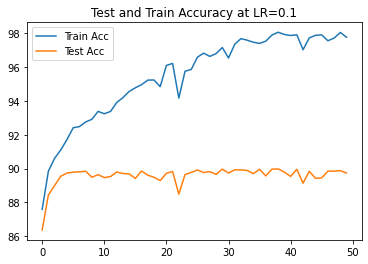

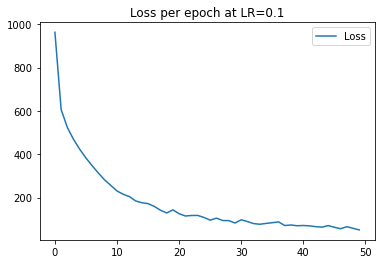

In [6]:
plt.plot(train_accuracy, label="Train Acc")
plt.plot(test_accuracy, label="Test Acc")
plt.title('Test and Train Accuracy at LR={}'.format(learning_rate))
plt.legend()
plt.show()

plt.plot(total_loss, label="Loss")
plt.title('Loss per epoch at LR={}'.format(learning_rate))
plt.legend()
plt.show()